In [1]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mapclassify as mc

In [2]:
def prepareData():
    geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

    # Make sure the "id" column is an integer
    geoData.id = geoData.id.astype(str).astype(int)

    # Remove Alaska, Hawaii and Puerto Rico.
    stateToRemove = ['02', '15', '72']
    geo_data = geoData[~geoData.STATE.isin(stateToRemove)]

    # Read data on counties and daily sunlight 
    solar_data = pd.read_csv('data/sunlight_data.txt', sep='\t')

    #include geospatial data with the solar data
    solar_data = geo_data.merge(solar_data, left_on=['id'], right_on=['County Code']);

    #define a county column to merge with pricing data
    def splitState(row):  
        return row['County'][-2:]

    solar_data['State'] = solar_data.apply(lambda row: splitState(row), axis=1)

    #get state by state average power costs 
    price_data = pd.read_csv('data/state_power_costs.csv')

    #include price data with the sunlight energy data
    solar_data = solar_data.merge(price_data, left_on=['State'], right_on=['State.1']);

    #convert KJ/M^2 of sunlight into kWh of electricity per year
    solar_data['kWh per year per m^2'] = solar_data['Avg Daily Sunlight (KJ/m2)']/3600*.15*365


    #multiply kWh per year per meter^2 by dollars per kWh = dollars per year per m^2
    solar_data['revenue per year per m^2'] = solar_data['kWh per year per m^2'] * solar_data['EIA Dollars per kWh']

    #include cost of panel per meter squared
    solar_data['upfront cost per m^2 before incentives'] = 968.0
    solar_data['upfront cost per m^2 after incentives'] = 716.0

    #compute payback period with and without incentives
    solar_data['resi_payback_years'] = solar_data['upfront cost per m^2 after incentives'] /solar_data['revenue per year per m^2']
    solar_data['commercial_payback_years'] = solar_data['upfront cost per m^2 before incentives'] /solar_data['revenue per year per m^2']
    
    return solar_data

In [3]:
def renderMap(input_data, field, cmap, title):
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    scheme = mc.Quantiles(input_data[field], k=15)
    gplt.choropleth(input_data, 
        hue=field, 
        linewidth=.1,
        scheme=scheme, cmap=cmap,
        legend=True,
        edgecolor='black',
        ax=ax
    );
    ax.set_title(title, fontsize=13);

def renderMapNoQuantiles(input_data, field, cmap, title):
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    gplt.choropleth(input_data, 
        hue=field, 
        linewidth=.1,
        cmap=cmap,
        legend=True,
        edgecolor='black',
        ax=ax
    );
    ax.set_title(title, fontsize=13);
    
def renderData(input_data):
    renderMap(input_data, 'kWh per year per m^2', 'plasma', "kWh per year per m^2")

/home/ec2-user/anaconda3/envs/geo_env/lib/python3.9/site-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


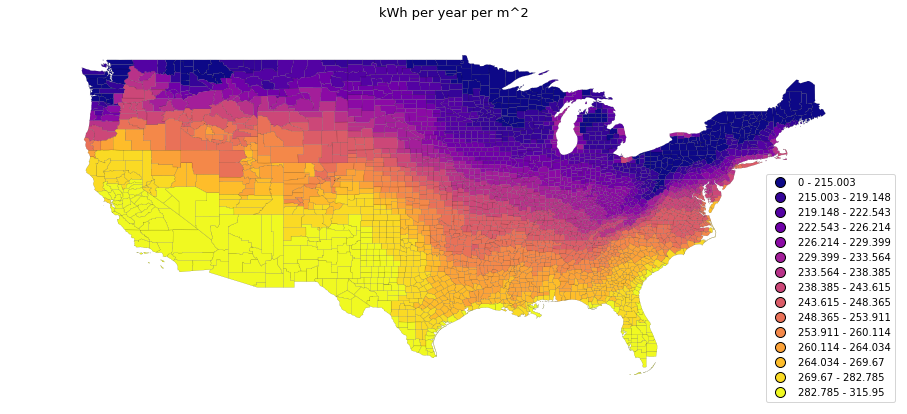

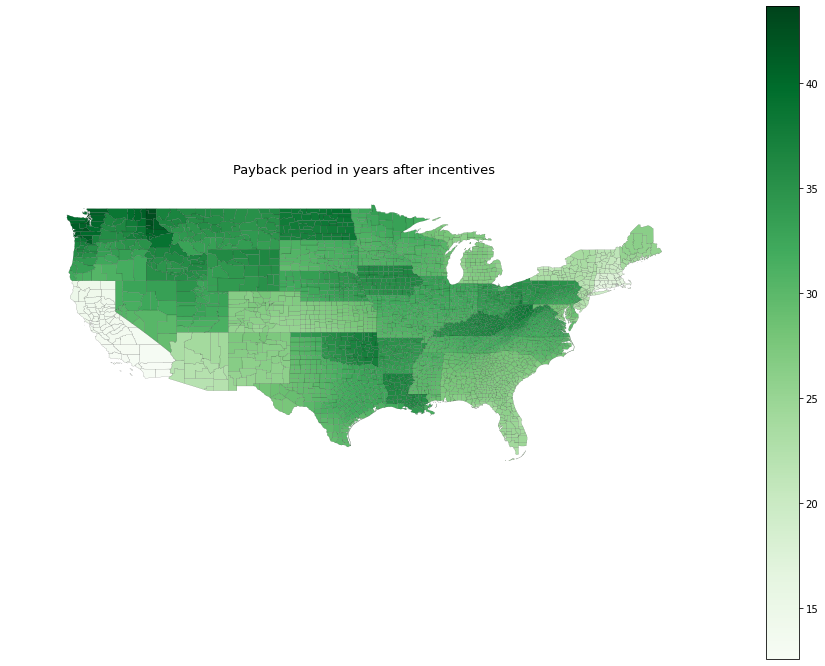

In [4]:
solar_data = prepareData()
renderMap(solar_data, 'kWh per year per m^2', 'plasma', "kWh per year per m^2")
renderMapNoQuantiles(solar_data, 'resi_payback_years', 'Greens', 'Payback period in years after incentives')

In [5]:
sorted_solar_data = solar_data[['revenue per year per m^2', 'resi_payback_years', 'County', 'geometry']].sort_values(by=['resi_payback_years'])

In [6]:
sorted_solar_data[50:100]

,revenue per year per m^2,resi_payback_years,County,geometry
188,49.998275,14.320494,"Lassen County, CA","POLYGON ((-120.00132 39.72242, -120.00132 39.7..."
167,49.905556,14.347100,"Tehama County, CA","POLYGON ((-122.93401 39.97813, -122.98962 40.1..."
147,49.534597,14.454544,"Shasta County, CA","POLYGON ((-123.06543 40.28697, -123.06879 40.3..."
197,49.453293,14.478308,"Trinity County, CA","POLYGON ((-123.06543 40.28697, -122.98901 40.2..."
195,48.903822,14.640982,"Siskiyou County, CA","POLYGON ((-122.28953 42.00776, -122.28953 42.0..."
187,48.697251,14.703089,"Humboldt County, CA","POLYGON ((-123.54446 40.00192, -124.02394 40.0..."
153,48.623968,14.725248,"Modoc County, CA","POLYGON ((-121.44754 41.99717, -121.43961 41.9..."
171,47.383141,15.110860,"Del Norte County, CA","POLYGON ((-124.06552 41.46474, -124.06606 41.4..."
493,44.559785,16.068300,"Fairfield County, CT","POLYGON ((-73.51747 41.66665, -73.51602 41.665..."
494,44.157130,16.214822,"New London County, CT","POLYGON ((-72.15755 41.65763, -72.15339 41.665..."
